<a href="https://colab.research.google.com/github/ChandanaS03/AI-Video-Enhancer/blob/WGAN-GP/WGan_GP_Natural_Low_light_Image_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install piqa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
from PIL import Image
import os
from google.colab import drive
import torchvision.models as models
import torch.nn.functional as F

# Mount Google Drive
drive.mount('/content/drive')

# Set dataset path
data_dir = "/content/drive/MyDrive/lol_dataset/our485"
low_light_dir = "/content/drive/MyDrive/lol_dataset/our485/low"
normal_light_dir = "/content/drive/MyDrive/lol_dataset/our485/high"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class LOLDataset(Dataset):
    def __init__(self, low_light_dir, normal_light_dir, transform=None):
        self.low_light_images = sorted(os.listdir(low_light_dir))
        self.normal_light_images = sorted(os.listdir(normal_light_dir))
        self.low_light_dir = low_light_dir
        self.normal_light_dir = normal_light_dir
        self.transform = transform

    def __len__(self):
        return len(self.low_light_images)

    def __getitem__(self, idx):
        low_light_path = os.path.join(self.low_light_dir, self.low_light_images[idx])
        normal_light_path = os.path.join(self.normal_light_dir, self.normal_light_images[idx])

        low_light = Image.open(low_light_path).convert("RGB")
        normal_light = Image.open(normal_light_path).convert("RGB")

        if self.transform:
            low_light = self.transform(low_light)
            normal_light = self.transform(normal_light)

        return low_light, normal_light


In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Increased size
    transforms.ToTensor(),
])

In [ ]:
dataset = LOLDataset(low_light_dir, normal_light_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(),
        )
        self.attention = nn.Sequential(
            nn.Conv2d(512, 512, 1, 1, 0),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        attention_map = self.attention(x1)
        x1 = x1 * attention_map
        x2 = self.decoder(x1)
        return x2


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(6, 64, 4, 2, 1)), nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
        )

        self.flatten = nn.Flatten()
        self.fc = None  # Placeholder for now

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)  # Concatenate low-light and normal images along the channel axis
        x = self.model(x)
        x = self.flatten(x)

        # Dynamically compute the correct input size for the Linear layer
        if self.fc is None:
            num_features = x.shape[1]  # Get flattened feature size
            self.fc = nn.Linear(num_features, 1).to(x.device)  # Initialize FC layer dynamically

        x = self.fc(x)
        return torch.clamp(x, -1, 1)



# Compute Gradient Penalty
def compute_gradient_penalty(D, real_samples, fake_samples, low_light_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(low_light_samples, interpolates)
    fake = torch.ones(real_samples.size(0), 1).to(device)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 30
lambda_gp = 5
lambda_l1 = 10

os.makedirs("results", exist_ok=True)

In [ ]:
for epoch in range(num_epochs):
    for i, (low_light, normal_light) in enumerate(dataloader):
        low_light = low_light.to(device)
        normal_light = normal_light.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        fake_images = generator(low_light)
        real_loss = -torch.mean(discriminator(low_light, normal_light))
        fake_loss = torch.mean(discriminator(low_light, fake_images.detach()))
        gradient_penalty = compute_gradient_penalty(discriminator, normal_light, fake_images, low_light)
        d_loss = real_loss + fake_loss + lambda_gp * gradient_penalty
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_images = generator(low_light)
        g_adv_loss = -torch.mean(discriminator(low_light, fake_images))
        g_l1_loss = nn.L1Loss()(fake_images, normal_light)
        g_loss = g_adv_loss + lambda_l1 * g_l1_loss
        g_loss.backward()
        optimizer_G.step()

        if i % 20 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} D Loss: {d_loss.item()} G Loss: {g_loss.item()}")
            save_image(fake_images, f"results/generated_{epoch}_{i}.png")

torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

Epoch [0/10] Batch 0/21 D Loss: 2.610264778137207 G Loss: 2.850273847579956
Epoch [1/10] Batch 0/21 D Loss: 3.8477590084075928 G Loss: 1.2682937383651733
Epoch [2/10] Batch 0/21 D Loss: 0.6247995495796204 G Loss: 1.7893526554107666
Epoch [3/10] Batch 0/21 D Loss: 0.6217647790908813 G Loss: 2.4806265830993652
Epoch [4/10] Batch 0/21 D Loss: 3.8286492824554443 G Loss: 2.157011032104492
Epoch [5/10] Batch 0/21 D Loss: -0.4230693578720093 G Loss: 2.6830451488494873
Epoch [6/10] Batch 0/21 D Loss: -0.36866170167922974 G Loss: 2.2125561237335205
Epoch [7/10] Batch 0/21 D Loss: -0.7127085328102112 G Loss: 2.0993738174438477
Epoch [8/10] Batch 0/21 D Loss: 2.329263210296631 G Loss: 2.4456210136413574
Epoch [9/10] Batch 0/21 D Loss: -0.9166361689567566 G Loss: 2.1548454761505127


In [ ]:
def test_model(image_path):
    generator.load_state_dict(torch.load("generator.pth", map_location=device))
    generator.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = generator(image)
    save_image(output, "enhanced_output.png")
    print("Enhanced image saved as enhanced_output.png")

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load trained Generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
generator.load_state_dict(torch.load("generator.pth", map_location=device))
generator.eval()  # Set to evaluation mode


<ipython-input-12-5de2393930cd>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth", map_location=device))


Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (attention): Sequential(
    (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

In [ ]:
# Define transformations (must match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize to match training size
    transforms.ToTensor(),
])

# Load and preprocess low-light image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure it's RGB
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image



In [ ]:
def enhance_image(image_path, save_path="enhanced.png"):
    low_light_image = load_image(image_path)

    with torch.no_grad():  # No gradients needed for inference
        enhanced_image = generator(low_light_image)

    # Convert tensor back to image
    enhanced_image = enhanced_image.squeeze(0).cpu().detach()  # Remove batch dim
    enhanced_image = transforms.ToPILImage()(enhanced_image)  # Convert to PIL

    # Save the enhanced image
    enhanced_image.save(save_path)
    print(f"Enhanced image saved at: {save_path}")

    # Display the image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path))
    plt.title("Low-Light Input")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_image)
    plt.title("Enhanced Output")
    plt.axis("off")

    plt.show()


Enhanced image saved at: enhanced.png


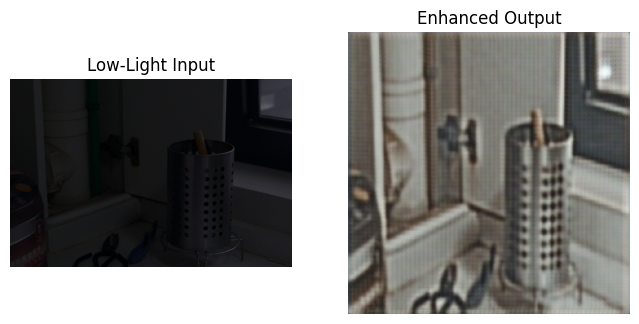

In [ ]:
# Replace with your test image path
test_image_path = "/content/drive/MyDrive/lol_dataset/eval15/low/111.png"
enhance_image(test_image_path)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import confusion_matrix

In [ ]:
import torch

# Load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models (ensure they match the architecture you trained)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Load trained weights
generator.load_state_dict(torch.load("generator.pth", map_location=device),strict=False)
discriminator.load_state_dict(torch.load("discriminator.pth", map_location=device),strict=False)

# Set models to evaluation mode
generator.eval()
discriminator.eval()

print("✅ Models loaded successfully!")


✅ Models loaded successfully!


<ipython-input-17-36e341b5040e>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth", map_location=device),strict=False)
<i

In [ ]:
psnr_values = []
ssim_values = []
gen_losses = []
disc_losses = []
y_true = []
y_pred = []

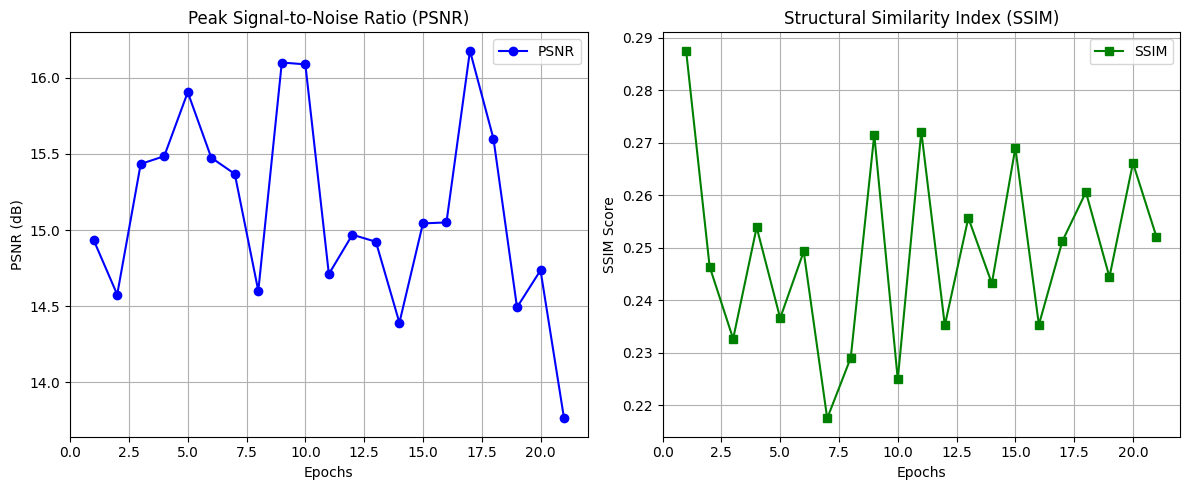

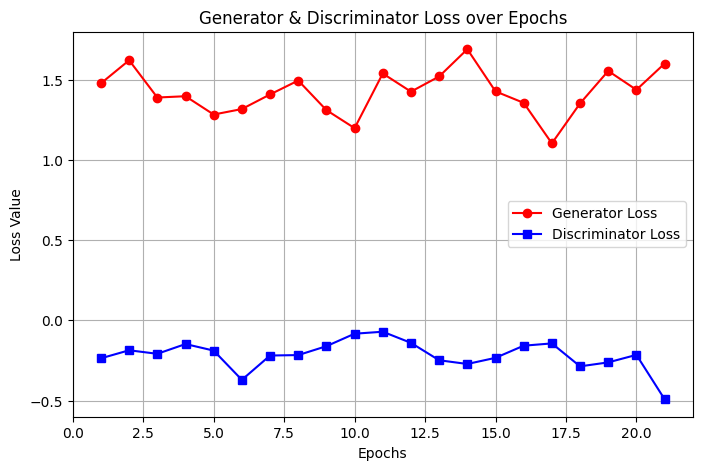

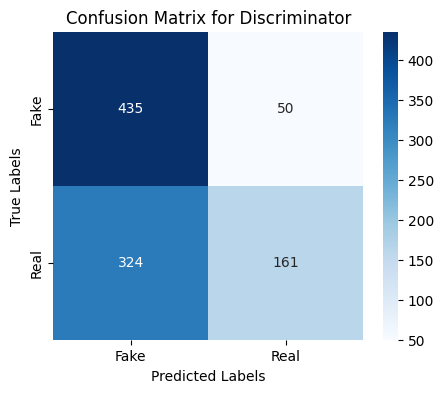

In [ ]:
with torch.no_grad():
    for i, (low_light, normal_light) in enumerate(dataloader):
        low_light = low_light.to(device)
        normal_light = normal_light.to(device)

        # Generate enhanced images
        fake_images = generator(low_light)

        # Compute PSNR & SSIM
        batch_psnr = []
        batch_ssim = []
        for j in range(fake_images.shape[0]):
            real = normal_light[j].cpu().numpy().transpose(1, 2, 0)
            fake = fake_images[j].cpu().numpy().transpose(1, 2, 0)

            batch_psnr.append(psnr(real, fake, data_range=1.0))
            batch_ssim.append(ssim(real, fake, multichannel=True, data_range=1.0,win_size=3))

        psnr_values.append(np.mean(batch_psnr))
        ssim_values.append(np.mean(batch_ssim))

        # Compute Generator Loss
        g_adv_loss = -torch.mean(discriminator(low_light, fake_images))
        g_l1_loss = F.l1_loss(fake_images, normal_light)
        g_loss = g_adv_loss + 10 * g_l1_loss
        gen_losses.append(g_loss.item())

        # Compute Discriminator Loss
        real_loss = -torch.mean(discriminator(low_light, normal_light))
        fake_loss = torch.mean(discriminator(low_light, fake_images.detach()))
        d_loss = real_loss + fake_loss
        disc_losses.append(d_loss.item())

        # Compute Discriminator Predictions
        real_preds = discriminator(low_light, normal_light).cpu().numpy()
        fake_preds = discriminator(low_light, fake_images).cpu().numpy()

        y_true.extend([1] * len(real_preds) + [0] * len(fake_preds))
        y_pred.extend([1 if p > 0.5 else 0 for p in real_preds] + [1 if p > 0.5 else 0 for p in fake_preds])
def plot_psnr_ssim(psnr_values, ssim_values):
    epochs = list(range(1, len(psnr_values) + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, psnr_values, marker='o', linestyle='-', color='b', label="PSNR")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR (dB)")
    plt.title("Peak Signal-to-Noise Ratio (PSNR)")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, ssim_values, marker='s', linestyle='-', color='g', label="SSIM")
    plt.xlabel("Epochs")
    plt.ylabel("SSIM Score")
    plt.title("Structural Similarity Index (SSIM)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_psnr_ssim(psnr_values, ssim_values)

# Plot Loss Curves
def plot_losses(gen_losses, disc_losses):
    epochs = list(range(1, len(gen_losses) + 1))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, gen_losses, marker='o', linestyle='-', color='r', label="Generator Loss")
    plt.plot(epochs, disc_losses, marker='s', linestyle='-', color='b', label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Generator & Discriminator Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(gen_losses, disc_losses)

# Plot Confusion Matrix for Discriminator
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix for Discriminator")
    plt.show()

plot_confusion_matrix(y_true, y_pred)

In [ ]:
print(len(dataloader))


61


In [ ]:
print(f"Epoch {num_epochs}, Iteration {i}")

Epoch 30, Iteration 39
